In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB == True:
    from google.colab import drive

    drive.mount("/content/gdrive")

    %cd /content/gdrive/MyDrive

    # if TP_wildfire_segmentation_ETU folder doesn't exist then clone the github project in /content/gdrive/MyDrive
    ! [ ! -d TP_wildfire_segmentation_ETU ] && git clone "https://github.com/ThomasLOUIS1/TP_wildfire_segmentation_ETU.git"

    # Go to the github project folder
    %cd /content/gdrive/MyDrive/TP_wildfire_segmentation_ETU/data

    # if dataset.zip dosn't exist then download it
    ! [ ! -f dataset.zip ] && echo "dataset.zip dosn't exist" && wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1idUH24mGyAegB0YzDcJmd9XyNVbqGsnS' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1idUH24mGyAegB0YzDcJmd9XyNVbqGsnS" -O dataset.zip && rm -rf /tmp/cookies.txt

    # if sample_data/RGB dosn't exist then exctract the dataset into sample_data/
    ! [ ! -d /content/sample_data/RGB ] && echo "data dosn't exist" && unzip -qq dataset.zip -d /content/sample_data

    data_dir = "/content/sample_data"

    %cd /content/gdrive/MyDrive/TP_wildfire_segmentation_ETU
else : 
    # if dataset.zip dosn't exist then download it
    ! [ ! -f data/dataset.zip ] && echo "dataset.zip doesn't exist" && wget -P data/ --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1idUH24mGyAegB0YzDcJmd9XyNVbqGsnS' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1idUH24mGyAegB0YzDcJmd9XyNVbqGsnS" -O dataset.zip && rm -rf /tmp/cookies.txt
    
    # if data/RGB dosn't exist then exctract the dataset into data/
    ! [ ! -d data/RGB ] && echo "data doesn't exist" && unzip -qq data/dataset.zip -d data/

    data_dir = "data/"

    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = "0"

# Wildfire Segmentation with Multi-spectral Images - Bonus

### Try finding the best combination of loss/weight/epochs/architecture to get a test f1_score higher than 98%.

# 0.1 Get dataset files paths

Loading a segmentation dataset differ from loading a classification dataset with a tensorflow or Keras function. When using Keras for MNIST for example, images are stored in folder correspondign to a class. In folder 0, there are all images for the number 0.

Here, we will not load data from classes since data do not belong to any classes. The segmentation task will generate a mask (having the same size as the input image) and each pixel of the mask is a value 0 or 1 corresponding to the fire/notfire class.

In [7]:
# Imports
import os
import PIL
from PIL import Image
import tensorflow as tf
import numpy as np


######################################
# Complete the folowing code replacing "______" : 
######################################
# Dataset folder paths declaration
RGB_dir = data_dir + "/RGB"                    # Only for display purpose
triband_dir = data_dir + "/tribands"    # Data directory
mask_dir = data_dir + "/masks"          # Labels directory

# Define images size
img_size = (256, 256)

######################################
######################################

######################################
# What's the purpose of the following function ?
# Answer : Get all tif files sorted by name in a directory and return as a sorted list..

def sort_tif_paths_from_folder(dir):
    """
    Get all tif files sorted by name in a directory and return as a sorted list.
    
    Parameters:
    dir (str): directory path containing the tif files

    Returns:
    list: sorted list of tif file paths in the directory
    """
    paths_list = sorted(
    [
        os.path.join(dir, fname)
        for fname in os.listdir(dir)
        if fname.endswith(".tif")
    ]
    )
    return paths_list
######################################
######################################

# Get sorted list of tif files for RGB images
RGB_img_paths = sort_tif_paths_from_folder(RGB_dir)

######################################
# Complete the folowing code replacing "______" : 
######################################
# Get sorted list of tif files for triband training images
triband_img_paths_train =   sort_tif_paths_from_folder(triband_dir + "/train" )
# Get sorted list of tif files for triband validation images
triband_img_paths_val   =   sort_tif_paths_from_folder(triband_dir + "/val")
# Get sorted list of tif files for triband test images
triband_img_paths_test  =   sort_tif_paths_from_folder(triband_dir + "/test")

# Get sorted list of tif files for mask training images
mask_img_paths_train  =   sort_tif_paths_from_folder(mask_dir + "/train")
# Get sorted list of tif files for mask validation images
mask_img_paths_val    =   sort_tif_paths_from_folder(mask_dir + "/val")
# Get sorted list of tif files for mask test images
mask_img_paths_test   =   sort_tif_paths_from_folder(mask_dir + "/test")
######################################
######################################

######################################
# Complete the folowing code replacing "______" : 
# The idea is to compute the number of samples we have. 
# Tips : you have to sum the length of triband_img_paths_train, triband_img_paths_val and triband_img_paths_test arrays
######################################
print("Number of samples from {} : {}".format(triband_dir, len(triband_img_paths_train)+len(triband_img_paths_val)+len(triband_img_paths_test)))
print("Number of samples from {} : {}".format(mask_dir, len(mask_img_paths_train)+len(mask_img_paths_val)+len(mask_img_paths_test)))
######################################
######################################

# Print 6 firsts paths from RGB, biband and mask paths
# Note: Only works for the first 15 because we don't have many RGB images
for RGB_path, triband_path, mask_path in zip(RGB_img_paths[:6], triband_img_paths_train[:6], mask_img_paths_train[:6]):
    print(RGB_path, "|", triband_path, "|", mask_path)


Number of samples from data//tribands : 1685
Number of samples from data//masks : 1685
data//RGB\_Sentinel-2 L1C from 2016-08-20_PasoRobles_BANDS-S2-L1C_0_0.tif | data//tribands/train\_Sentinel-2 L1C from 2016-08-20_PasoRobles_BANDS-S2-L1C_0_0.tif | data//masks/train\_Sentinel-2 L1C from 2016-08-20_PasoRobles_BANDS-S2-L1C_0_0.tif
data//RGB\_Sentinel-2 L1C from 2016-08-20_PasoRobles_BANDS-S2-L1C_0_1.tif | data//tribands/train\_Sentinel-2 L1C from 2016-08-20_PasoRobles_BANDS-S2-L1C_0_1.tif | data//masks/train\_Sentinel-2 L1C from 2016-08-20_PasoRobles_BANDS-S2-L1C_0_1.tif
data//RGB\_Sentinel-2 L1C from 2016-08-20_PasoRobles_BANDS-S2-L1C_0_10.tif | data//tribands/train\_Sentinel-2 L1C from 2016-08-20_PasoRobles_BANDS-S2-L1C_0_10.tif | data//masks/train\_Sentinel-2 L1C from 2016-08-20_PasoRobles_BANDS-S2-L1C_0_10.tif
data//RGB\_Sentinel-2 L1C from 2016-08-20_PasoRobles_BANDS-S2-L1C_0_11.tif | data//tribands/train\_Sentinel-2 L1C from 2016-08-20_PasoRobles_BANDS-S2-L1C_0_11.tif | data//mask

# 0.2 Load dataset

In [8]:
batch_size = 16
######################################
# Complete the folowing code replacing "______" : 
######################################
def load_triband_and_mask_from_paths(paths = None):
    """
    Load the tri-bands and mask images data from the given paths and convert them into a tensorflow dataset.
    
    Parameters:
    paths (List): List of tuples of tri-bands and mask image paths
    
    Returns:
    data (tf.data.Dataset): A tensorflow dataset object with tri-bands and mask images data.
    """
    
    # Initialize arrays to store tri-bands image data and mask image data
    x = np.zeros((len(paths),) + img_size + (3,), dtype="float32")
    y = np.zeros((len(paths),) + img_size + (1,), dtype="float32")
    
    # Loop through the list of tri-bands and mask image paths
    for i, (triband_path, mask_path)  in enumerate(paths):
        
        # Read the tri-bands image file and normalize the data
        triband = np.array(Image.open(triband_path)) / 255.0
        x[i] = triband
        
        # Open the mask image file
        mask = np.array(Image.open(mask_path))
        # Add an extra dimension to the mask data for compatibility with the model
        mask = np.expand_dims(mask, 2) # Same as np.reshape(mask, (256,256,1))
        y[i] = mask
        
    # Create a tensorflow dataset from tri-bands and mask image data
    data = tf.data.Dataset.from_tensor_slices((x, y))
    
    # Batch the dataset and fetch the data in advance for faster processing
    data = data.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return data
######################################
######################################

In [9]:
# Create tuples of (Tri-bands image path, mask image path) for train, val and test datasets
train_paths = list(zip(triband_img_paths_train, mask_img_paths_train))
val_paths = list(zip(triband_img_paths_val, mask_img_paths_val))
test_paths = list(zip(triband_img_paths_test, mask_img_paths_test))

######################################
# Complete the folowing code replacing "______" : 
######################################
# Load train, val and test datasets from the tuple of Tri-bands and mask image paths
train_ds =  load_triband_and_mask_from_paths(train_paths)
val_ds = load_triband_and_mask_from_paths(val_paths)
test_ds = load_triband_and_mask_from_paths(test_paths)
######################################
######################################

# 0.4 Declaration of all loss, metrics etc...

In [10]:
from metrics_and_losses import recall_m, precision_m, f1_m

from utils import predict, print_score, display_confusion_matrix, display_sample_prediction, load_masks

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, Flatten, Dense, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K


def weighted_binary_crossentropy( y_true, y_pred) :
        y_true = K.clip(y_true, K.epsilon(), 1-K.epsilon())
        y_pred = K.clip(y_pred, K.epsilon(), 1-K.epsilon())
        logloss = -(y_true * K.log(y_pred) * ones_weight + (1 - y_true) * K.log(1 - y_pred) * zeros_weight )
        return K.mean( logloss, axis=-1)

# The Dice loss function we will use in the model.compile
def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)

def weighted_binary_crossentropy_and_dice(y_true, y_pred):
    return weighted_binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


# 1.1 Build the model

Here you will find a very basic CNN.

In [11]:
model = None

model = Sequential()

model.add(Conv2D(4, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)))
model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 4)       112       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 1)       37        
                                                                 
Total params: 149
Trainable params: 149
Non-trainable params: 0
_________________________________________________________________


# 1.2 Train the model

Choose your hyperparameters

In [12]:
####
# If weighted_binary_crossentropy used
ones_weight = 26.0
zeros_weight = 1.0
####
loss = weighted_binary_crossentropy
learning_rate=0.01
batch_size = 16
epochs = 4

In [13]:
metrics = [tf.keras.metrics.BinaryAccuracy(), recall_m, precision_m, f1_m]

from tensorflow.keras.callbacks import EarlyStopping 

callback = EarlyStopping(monitor=f1_m, mode = 'max', patience=5)

model.compile(optimizer = Adam(learning_rate=learning_rate), metrics = metrics, loss = loss)

history = model.fit(train_ds, epochs = epochs, validation_data = val_ds, batch_size=batch_size, callbacks = [callback])

Epoch 1/8
64/64 [==============================] - 7s 22ms/step - loss: 0.3269 - binary_accuracy: 0.9958 - recall_m: 1.4468e-04 - precision_m: 2.0104e-07 - f1_m: 4.0153e-07 - val_loss: 0.1727 - val_binary_accuracy: 0.9987 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/8
64/64 [==============================] - 1s 15ms/step - loss: 0.1818 - binary_accuracy: 0.9982 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 0.0876 - val_binary_accuracy: 0.9987 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/8
64/64 [==============================] - 1s 14ms/step - loss: 0.0917 - binary_accuracy: 0.9982 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 0.0649 - val_binary_accuracy: 0.9987 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/8
64/64 [==============================] - 1s 16ms/step - loss: 0.0740 - binary_accura

# 1.3 Evaluate the model 

In [14]:
model_score = model.evaluate(test_ds)
print_score(model_score)

21/21 [==============================] - 0s 9ms/step - loss: 0.0408 - binary_accuracy: 0.9988 - recall_m: 0.5926 - precision_m: 0.6975 - f1_m: 0.5967
|loss: 4.08%|	|Accuracy: 99.88%|	|Recall: 59.26%|	|Precision: 69.75%|	|f1_score: 59.67%|	

# 1.4 Display predictions

Image n 2, path : data//tribands/test\_Sentinel-2 L1C from 2016-08-20_PasoRobles_BANDS-S2-L1C_0_6.tif


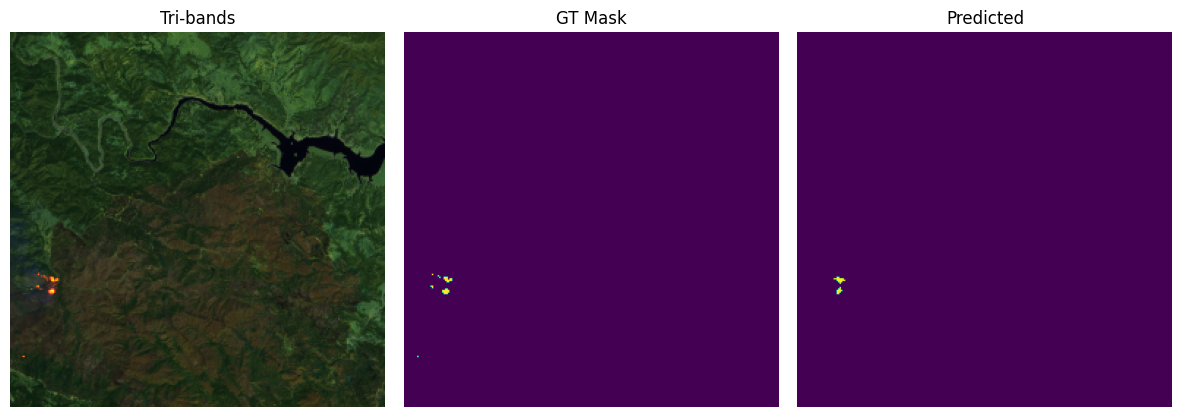

Image n 4, path : data//tribands/test\_Sentinel-2 L1C from 2016-09-25_Cloverdale_BANDS-S2-L1C_0_1.tif


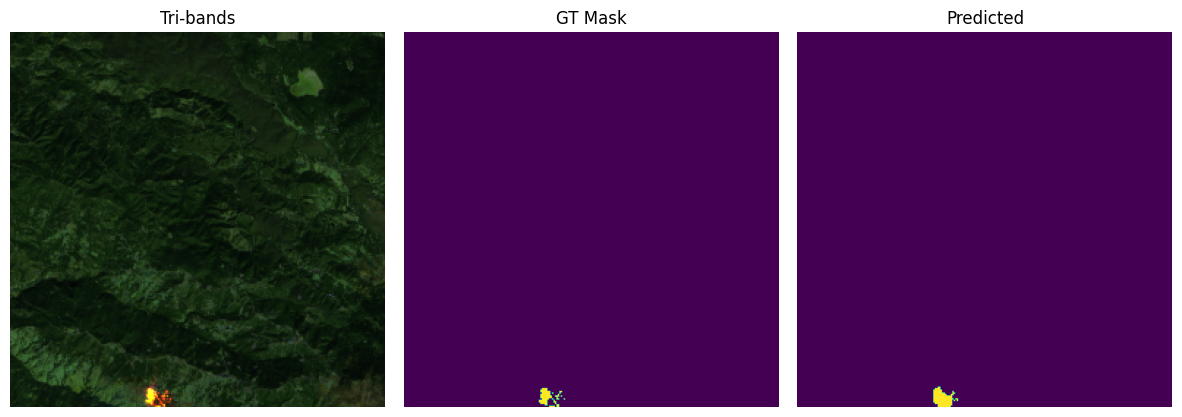

Image n 5, path : data//tribands/test\_Sentinel-2 L1C from 2017-07-24_ProençaANova_BANDS-S2-L1C_0_8.tif


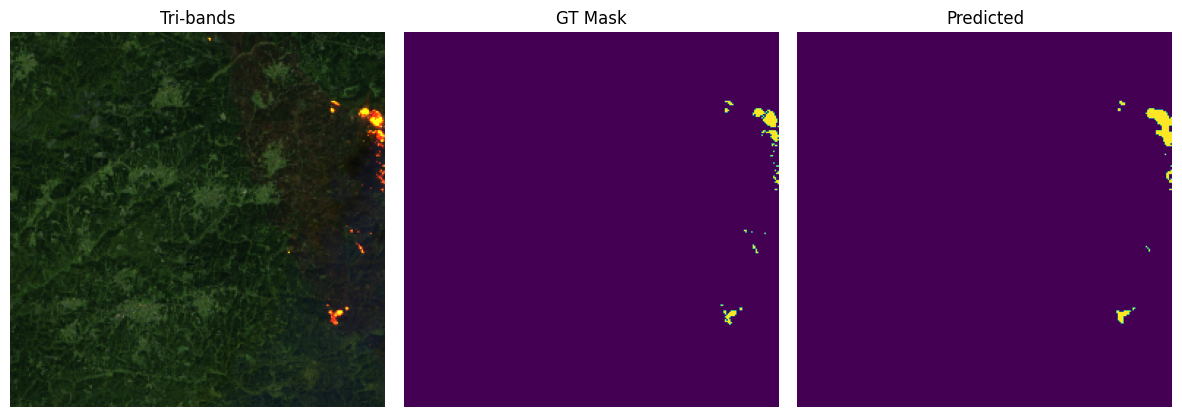

In [15]:
# Diplay Tri-bands, mask and prediction of the model2
display_sample_prediction(model, triband_img_paths_test, mask_img_paths_test)

We can see it with a Confusion Matrix

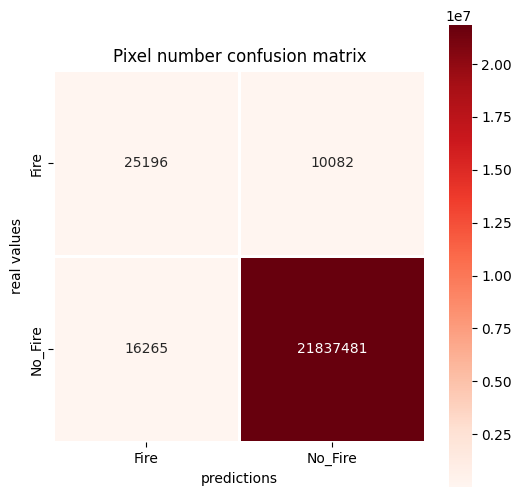

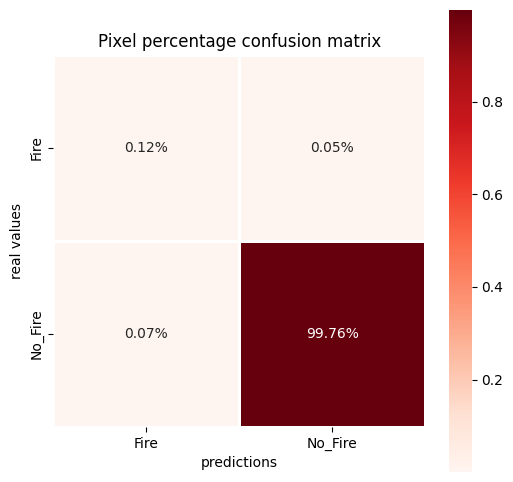

In [16]:
test_gt_masks = load_masks(mask_img_paths_test, img_size=img_size)

display_confusion_matrix(predict(model, test_ds), test_gt_masks)

Print scores again ...

In [17]:
print_score(model_score)

|loss: 4.08%|	|Accuracy: 99.88%|	|Recall: 59.26%|	|Precision: 69.75%|	|f1_score: 59.67%|	

# 1.5 Track your tests if you want !  

| test n°       |example| 1     | 2     | 3     | 4     | 5     | 6     | 7     | 8     | 9     | 10    | ...   | 
| ---           | ---   | ---   | ---   | ---   | ---   | ---   | ---   | ---   | ---   | ---   | ---   | ---   |
| f1_score      | 0.83  | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     |
| recall        | 0.97  | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     |
| precision     | 0.72  | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     |
| epochs        | 4     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     |
| batch_size    | 16    | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     |
| learning rate | 0.01  | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     |
| loss          | Dice  | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     |
| class weight  | None  | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     |
| n conv2d      | 3     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     |
| n conv2dT     | 2     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     |
| n params      | 1033  | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     | ?     |